In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sksurv.util import Surv
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import integrated_brier_score
from sksurv.metrics import concordance_index_censored

from lifelines import CoxPHFitter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import fonctions_SurvTreeShap as fstp

from survshap import SurvivalModelExplainer, PredictSurvSHAP

ModuleNotFoundError: No module named 'survshap'

In [54]:
import importlib
importlib.reload(fonctions_SurvTreeShap)

NameError: name 'fonctions_SurvTreeShap' is not defined

In [79]:
np.random.seed(36)

n = 10000

# X1 : effet réel
X1 = np.random.normal(size=n)

# X2 : fortement corrélée à X1 mais sans effet
X2 = 0.5 * X1 + np.random.normal(scale=0.1, size=n)

# X3 : effet modéré positif
X3 = np.random.normal(size=n)

# X4 : effet faible négatif
X4 = np.random.normal(size=n)

# X5 : aucun effet
X5 = np.random.normal(size=n)

# Coefficients simulés
beta1 = 1.0   # X1
beta2 = 0.0   # X2
beta3 = 1   # X3
beta4 = -0.3  # X4
beta5 = 0.0   # X5

# Prédicteur linéaire pour générer les taux
linpred = beta1 * X1 + beta3 * X3 + beta4 * X4
lambda_ = np.exp(linpred)

# Temps de survie simulés (distribution exponentielle)
T = np.random.exponential(scale=1/lambda_)

# Temps de censure aléatoire
C = np.random.exponential(scale=10, size=n)

# Temps observés et indicateur de censure
observed_time = np.minimum(T, C)
event_observed = (T <= C).astype(int)

# Création du DataFrame
df = pd.DataFrame({
    'time': observed_time,
    'event': event_observed,
    'X1': X1,
    'X2': X2,
    'X3': X3,
    'X4': X4,
    'X5': X5
})

In [80]:
print(df.head())

       time  event        X1        X2        X3        X4        X5
0  0.032287      0  0.676413  0.375692 -0.204092  0.348241  0.544973
1  2.245720      1  1.521099  0.871730 -1.389283  1.215616  0.820599
2  0.739904      1 -0.511876 -0.032647  1.372677 -2.164650  0.385178
3  2.429180      1  1.150195  0.658470 -1.425445 -0.827347  0.781083
4  0.765412      1 -0.590717 -0.388347 -0.605587 -0.320603  2.248140


In [81]:
Xe = df[['X1', 'X2', 'X3', 'X4', 'X5']].copy()
ye = df[['event', 'time']].copy()
X_train, X_test, y_train, y_test = train_test_split(Xe, ye, test_size=0.2, random_state=42)

In [82]:
y_train_RSF = Surv.from_dataframe("event", "time", y_train)
y_test_RSF = Surv.from_dataframe("event", "time", y_test)

In [83]:
rsf2 = RandomSurvivalForest(n_estimators=100, random_state=42, max_depth=3)
rsf2.fit(X_train, y_train_RSF)

RandomSurvivalForest(max_depth=3, random_state=42)

100%|██████████| 8000/8000 [00:59<00:00, 134.14it/s]


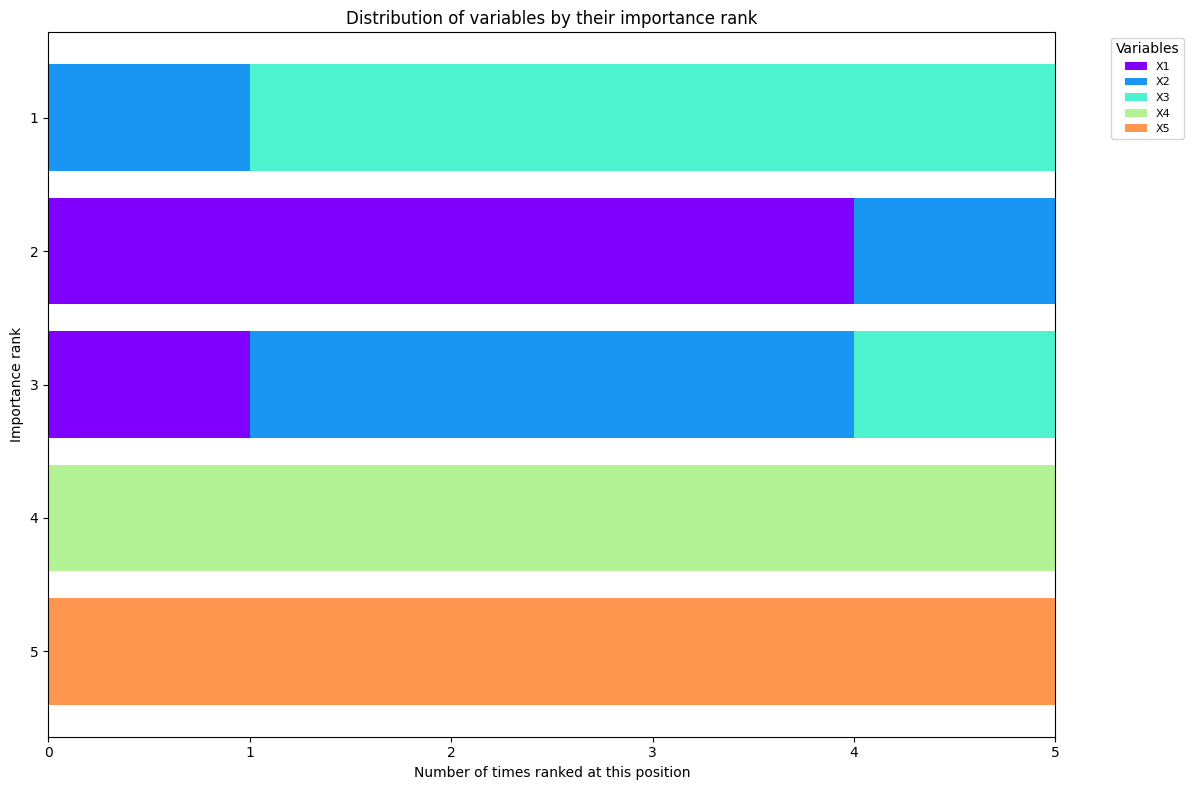

In [85]:
STS=fstp.SurvTreeSHAPexplainer(rsf2, X_test)
STS.rankvariables(5)


100%|██████████| 800/800 [00:05<00:00, 144.57it/s]


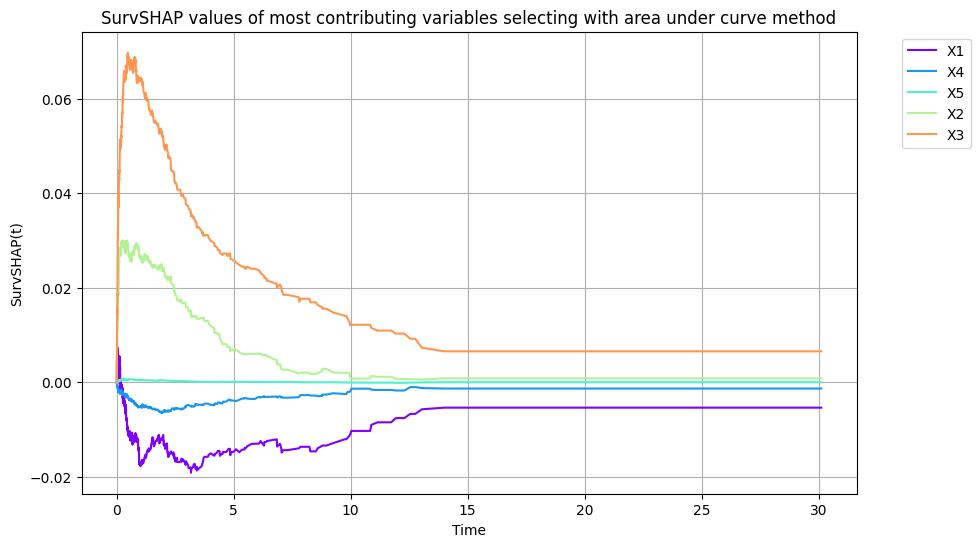

In [84]:
STS.plotgraph(6, "area", 0, 5)

In [135]:

np.random.seed(42)
n = 1000

# Covariables
X = pd.DataFrame({
    'age': np.random.normal(50, 10, size=n),
    'sex': np.random.choice([0, 1], size=n),
    'smoking': np.random.choice([0, 1], size=n),
    'cholesterol': np.random.normal(200, 50, size=n),
    'blood_pressure': np.random.normal(120, 15, size=n),
    'diabetes': np.random.choice([0, 1], size=n),
    'exercise': np.random.choice([0, 1], size=n),
    'alcohol': np.random.choice([0, 1], size=n),
    'weight': np.random.normal(70, 10, size=n),
    'height': np.random.normal(170, 10, size=n)
})

# Coefficients de base
beta_static = np.array([-0.03, 0.2, 0.0, 0.01, -0.005, 0.3, 0.0, 0.05, -0.01, 0.005])

# Grille temporelle
t_grid = np.linspace(0.1, 100, 1000)
dt = t_grid[1] - t_grid[0]

# Risque de base plus faible
baseline_hazard = 0.0005
survival_time = np.zeros(n)

for i in range(n):
    x_i = X.iloc[i].values

    # Effets non proportionnels plus doux
    beta_smoking_t = 0.02 + 0.05 * t_grid
    beta_exercise_t = -0.03 - 0.05 * t_grid

    static_effect = np.dot(x_i, beta_static)
    lp_t = static_effect + beta_smoking_t * x_i[2] + beta_exercise_t * x_i[6]

    hazard = baseline_hazard * np.exp(lp_t)
    cum_hazard = np.cumsum(hazard) * dt
    S = np.exp(-cum_hazard)

    # Simulation d’un temps de survie basé sur S(t)
    u = np.random.uniform()
    idx = np.searchsorted(S[::-1], u)
    idx = len(t_grid) - idx - 1
    idx = np.clip(idx, 0, len(t_grid) - 1)
    survival_time[i] = t_grid[idx]

# Censure aléatoire
censoring_time = np.random.uniform(0, 100, size=n)
event_observed = survival_time <= censoring_time
observed_time = np.minimum(survival_time, censoring_time)

# Format pour scikit-survival
y = Surv.from_arrays(event_observed, observed_time)

# DataFrame résumé
y_df = pd.DataFrame({
    "event": event_observed.astype(int),
    "time": observed_time
})

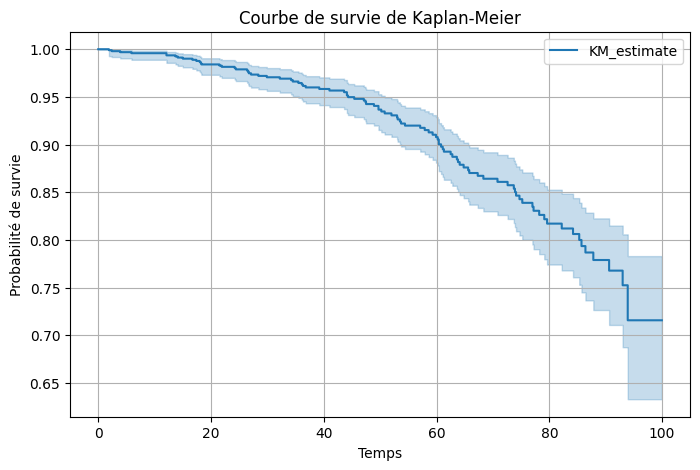

In [136]:
from lifelines import KaplanMeierFitter

# Initialiser l'objet Kaplan-Meier
kmf = KaplanMeierFitter()

# Ajuster le modèle aux données simulées
kmf.fit(durations=y_df["time"], event_observed=y_df["event"])

# Tracer la courbe de survie
plt.figure(figsize=(8, 5))
kmf.plot(ci_show=True)
plt.title("Courbe de survie de Kaplan-Meier")
plt.xlabel("Temps")
plt.ylabel("Probabilité de survie")
plt.grid(True)
plt.show()

In [137]:
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index

data_full = pd.concat([X, y_df], axis=1)

# 1. Créer le CoxPHFitter
cph = CoxPHFitter()

# 2. Ajuster le modèle sur les données
cph.fit(data_full, duration_col='time', event_col='event')

# 3. Afficher le résumé des coefficients
cph.print_summary()

# 4. Calcul du C-index (valeurs proches de 1 = très bon modèle)
c_index = concordance_index(data_full['time'], -cph.predict_partial_hazard(data_full), data_full['event'])

print(f"\nC-index (modèle de Cox) : {c_index:.3f}")


<lifelines.CoxPHFitter: fitted with 1000 total observations, 905 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 1000
number of events observed = 95
   partial log-likelihood = -476.21
         time fit was run = 2025-05-12 08:58:59 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
age            -0.03      0.97      0.01           -0.05           -0.01                0.95                0.99
sex             0.14      1.16      0.21           -0.27            0.56                0.77                1.74
smoking         2.10      8.21      0.29            1.54            2.67                4.66               14.45
cholesterol     0.01      1.01      0.00            0.01            0.02                1.01                1.02
blood_pressure -0.01      0.99      0.01           -0.02            0.01                0.98                1.01
diabetes        0.45      1.57      0.21            0.03            0.87                1.04                2.39
exercise       -2.47      0.08      0.32           -3.10           -1.84                0.05                0.16
alcohol        -0.09      0.91      0.21           -0.50            0.32                0.60                1.37
weight          0.01      1.01      0.01           -0.01            0.03                0.99                1.03
height          0.01      1.01      0.01           -0.02            0.03                0.98                1.03

                cmp to     z      p  -log2(p)
covariate                                    
age               0.00 -2.59   0.01      6.69
sex               0.00  0.69   0.49      1.03
smoking           0.00  7.29 <0.005     41.58
cholesterol       0.00  5.47 <0.005     24.44
blood_pressure    0.00 -0.96   0.34      1.56
diabetes          0.00  2.12   0.03      4.88
exercise          0.00 -7.74 <0.005     46.49
alcohol           0.00 -0.44   0.66      0.61
weight            0.00  0.87   0.38      1.38
height            0.00  0.53   0.59      0.75
---
Concordance = 0.80
Partial AIC = 972.43
log-likelihood ratio test = 182.96 on 10 df
-log2(p) of ll-ratio test = 110.44


C-index (modèle de Cox) : 0.803


<Axes: xlabel='log(HR) (95% CI)'>

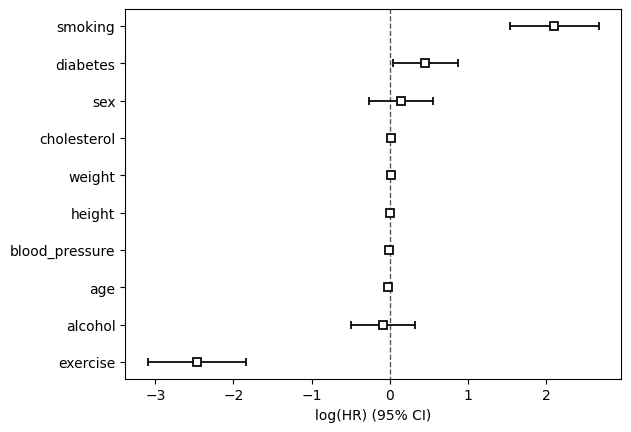

In [138]:
cph.plot()

In [139]:
Xc = X
yc = y_df
X_train, X_test, y_train, y_test = train_test_split(Xc, yc, test_size=0.2, random_state=42)


In [140]:
y_train_RSF = Surv.from_dataframe("event", "time", y_train)
y_test_RSF = Surv.from_dataframe("event", "time", y_test)

In [141]:
rsf = RandomSurvivalForest(n_estimators=100, random_state=42, max_depth=3)
rsf.fit(X_train, y_train_RSF)

RandomSurvivalForest(max_depth=3, random_state=42)

In [142]:
y_pred_rsf = rsf.predict(X_test)
c_index = concordance_index_censored(y_test_RSF["event"], y_test_RSF["time"], y_pred_rsf)[0]
c_index

np.float64(0.6801152737752162)

In [123]:
X_test

,age,sex,smoking,cholesterol,blood_pressure,diabetes,exercise,alcohol,weight,height
521,55.433602,1,1,190.840169,125.424916,1,1,0,74.283421,155.930225
737,59.826910,1,1,184.323516,144.437495,0,1,0,63.961411,156.003185
740,31.591258,1,0,221.004725,117.030934,1,1,0,79.737262,165.865762
660,44.263380,0,0,214.711206,118.327368,0,1,1,73.278111,173.735337
411,38.753579,1,0,200.957389,91.752747,1,0,1,47.505675,170.645060
...,...,...,...,...,...,...,...,...,...,...
408,51.202956,1,1,209.485308,96.974396,1,0,0,74.316316,168.283263
332,50.758046,1,1,71.883317,135.730607,0,0,1,76.963229,166.532284
208,55.150477,1,1,217.572410,105.721223,1,0,0,75.496832,173.374821
613,38.745110,1,1,203.467217,113.934039,1,1,1,70.156822,152.069236


100%|██████████| 798/798 [00:05<00:00, 150.07it/s]


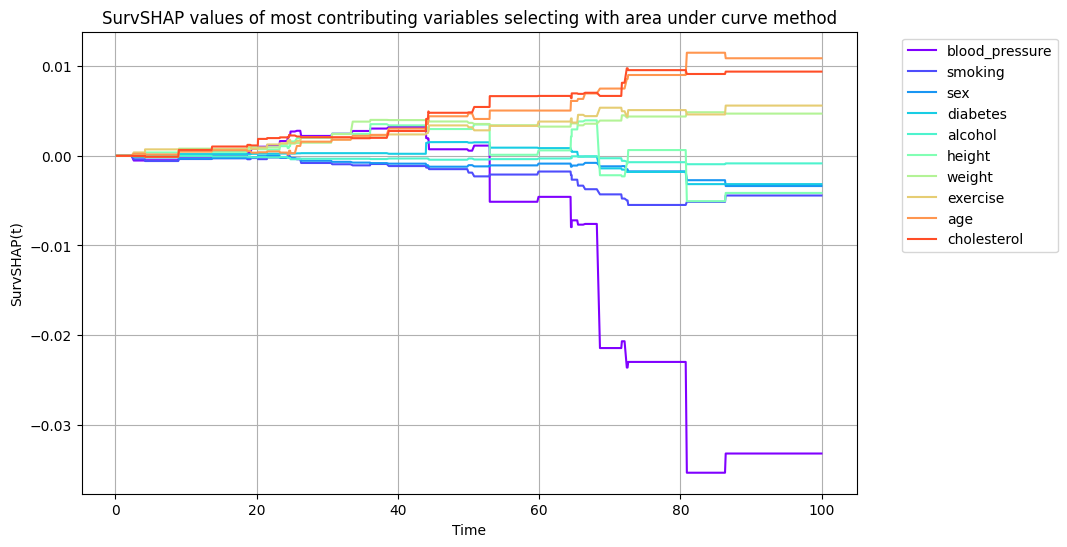

In [125]:
STS=fstp.SurvTreeSHAPexplainer(rsf, X_test)
STS.plotgraph(1, "area", 0, 10)


100%|██████████| 798/798 [00:04<00:00, 169.32it/s]


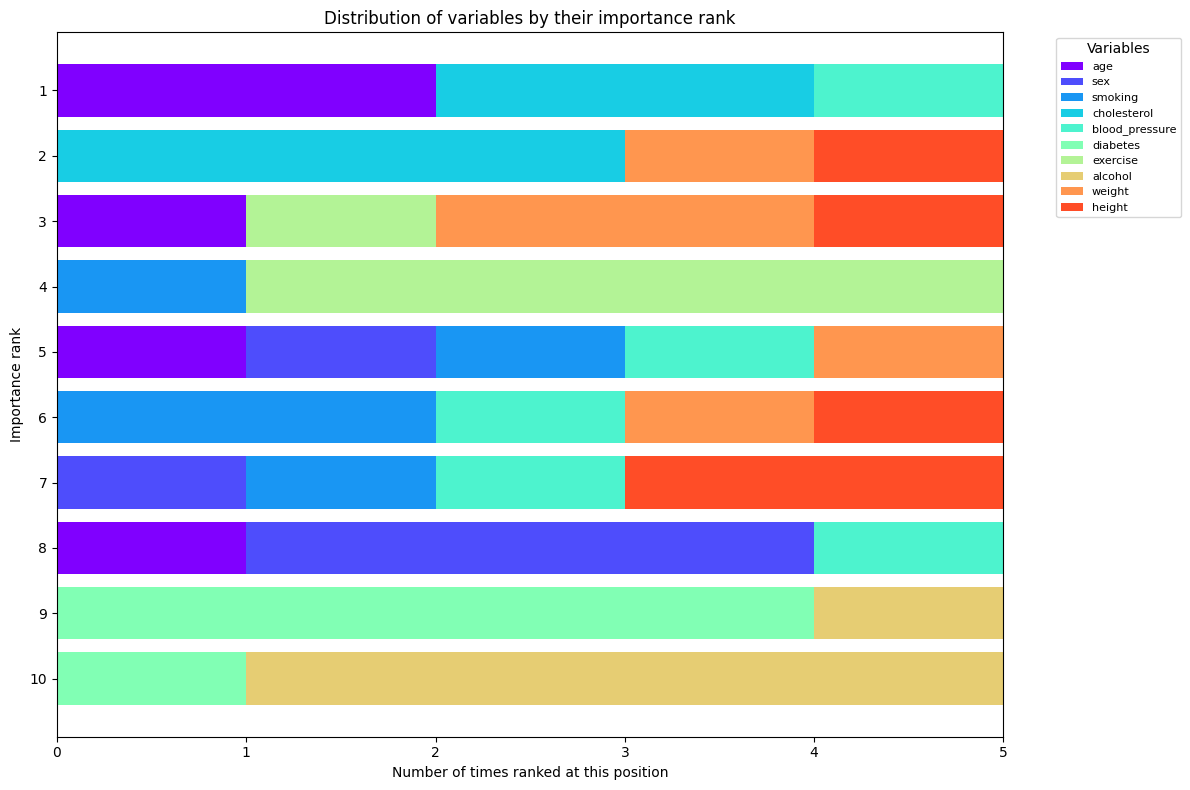

In [126]:
STS.rankvariables(5)